# Assignment

Pick a year from the [Boston Marathon dataset](https://github.com/llimllib/bostonmarathon) and do some clustering.

Specifically, you must:
- Use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. 
- Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. 
- Write up your report, including your process from start to finish, in a Jupyter notebook and submit it.

### Import Statements

In [296]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

### The Dataframe

I'll look at the 2014 Boston Marathon data for this analysis.

In [297]:
marathon_df = pd.read_csv('Boston Marathon Results.csv')

### Exploratory Data Analysis

_Getting a Sense of What the Dataframe's Like_

In [298]:
marathon_df.describe()

,division,age,official,genderdiv,overall,pace
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,1932.563032,42.407079,242.997314,8051.044741,15939.587825,9.275658
std,1715.228694,11.316496,52.300431,4754.005626,9232.978224,1.992486
min,1.000000,18.000000,80.600000,1.000000,1.000000,3.080000
25%,610.000000,33.000000,205.527500,3972.000000,7943.750000,7.850000
50%,1425.000000,42.000000,232.370000,7970.000000,15939.500000,8.870000
75%,2611.000000,50.000000,273.235000,11968.000000,23935.250000,10.430000
max,6979.000000,81.000000,538.880000,17575.000000,31931.000000,20.570000


In [299]:
marathon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 3.3+ MB


_Understanding the "Object" Variables_

In [300]:
marathon_df[['10k', 'name', '25k', 'gender', 'bib', 'ctz', '35k', 'state', '30k', '5k', 'half', '20k', 'country', 'city',
            '40k']].head(5)

,10k,name,25k,gender,bib,ctz,35k,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",47.67,M,W1,NaN,71.40,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",82.43,F,F1,NaN,116.37,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",45.80,M,W2,NaN,67.42,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",82.43,F,F2,NaN,116.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",46.37,M,W3,NaN,67.83,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


_Dropping Variables_

In [301]:
# Dropping the 'ctz', 'state', 'name', 'bib', 'city' and 'country' columns because it's not clear to me that there's a good 
# way to replace the missing values.

marathon_df = marathon_df.drop(columns=['ctz', 'state', 'name', 'bib', 'city', 'country'])

_Converting the Distance Variables from Objects to FLoats_

In [302]:
marathon_df[['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']].describe()

,10k,25k,35k,30k,5k,half,20k,40k
count,31984,31984,31984,31984,31984,31984,31984,31984
unique,2766,6570,9516,8090,1491,5651,5375,10546
top,-,-,-,-,23.93,-,-,-
freq,50,216,34,40,81,72,51,39


In [303]:
# Some values were dashes, so I'm going to replace those with zeros, then replace the zeros with the median value
# for each distance.

marathon_df['10k'] = marathon_df['10k'].replace('-', 0)
marathon_df['25k'] = marathon_df['25k'].replace('-', 0)
marathon_df['30k'] = marathon_df['30k'].replace('-', 0)
marathon_df['35k'] = marathon_df['35k'].replace('-', 0)
marathon_df['5k'] = marathon_df['5k'].replace('-', 0)
marathon_df['half'] = marathon_df['half'].replace('-', 0)
marathon_df['20k'] = marathon_df['20k'].replace('-', 0)
marathon_df['40k'] = marathon_df['40k'].replace('-', 0)

In [304]:
print(marathon_df['10k'].median())
print(marathon_df['25k'].median())
print(marathon_df['30k'].median())
print(marathon_df['35k'].median())
print(marathon_df['5k'].median())
print(marathon_df['half'].median())
print(marathon_df['20k'].median())
print(marathon_df['40k'].median())

50.32
128.67
157.7
188.12
25.08
107.775
102.1
218.78


In [305]:
marathon_df['10k'] = marathon_df['10k'].replace('-', 50.32)
marathon_df['25k'] = marathon_df['25k'].replace('-', 128.67)
marathon_df['30k'] = marathon_df['30k'].replace('-', 157.7)
marathon_df['35k'] = marathon_df['35k'].replace('-', 188.12)
marathon_df['5k'] = marathon_df['5k'].replace('-', 25.08)
marathon_df['half'] = marathon_df['half'].replace('-', 107.78)
marathon_df['20k'] = marathon_df['20k'].replace('-', 102.1)
marathon_df['40k'] = marathon_df['40k'].replace('-', 218.78)

In [306]:
marathon_df[['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']] = marathon_df[['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']].astype(float)

In [307]:
marathon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 15 columns):
10k          31984 non-null float64
division     31984 non-null int64
25k          31984 non-null float64
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
genderdiv    31984 non-null int64
35k          31984 non-null float64
overall      31984 non-null int64
pace         31984 non-null float64
30k          31984 non-null float64
5k           31984 non-null float64
half         31984 non-null float64
20k          31984 non-null float64
40k          31984 non-null float64
dtypes: float64(10), int64(4), object(1)
memory usage: 3.5+ MB


_Converting the Gender Variable to Numbers Using Get Dummies_

In [308]:
marathon_df['gender'] = pd.get_dummies(marathon_df['gender'], drop_first=True)

_Checking for Missing Values_

In [309]:
(marathon_df.isnull().sum()*100) / marathon_df.isnull().count()

10k          0.0
division     0.0
25k          0.0
gender       0.0
age          0.0
official     0.0
genderdiv    0.0
35k          0.0
overall      0.0
pace         0.0
30k          0.0
5k           0.0
half         0.0
20k          0.0
40k          0.0
dtype: float64

### Clusters

In [311]:
# Define the features and the outcome.
X = marathon_df.iloc[:, :14]
y = marathon_df.iloc[:, 14]

_K-Means_

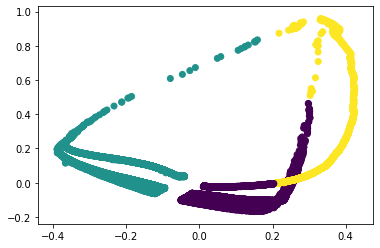

In [314]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to three components.
X_pca = PCA(3).fit_transform(X_norm)

# Calculate predicted values.
cluster = KMeans(n_clusters=3, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

_Mini Batch K-Means_

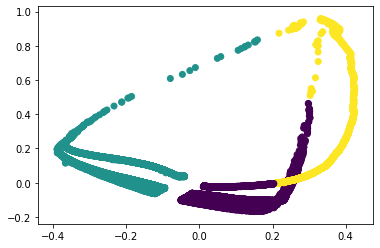

In [315]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=3,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

_Mean Shift_

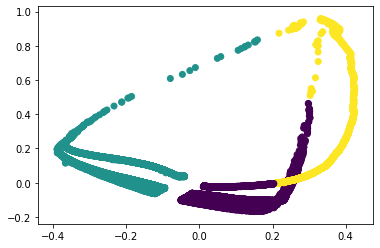

In [316]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to three components.
X_pca = PCA(3).fit_transform(X_norm)

# Calculate predicted values.
cluster = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

_Spectral Clustering_

In [317]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to three components.
X_pca = PCA(3).fit_transform(X_norm)

# Declare and fit the model.
cluster = SpectralClustering(n_clusters=3).fit_predict(X_pca)

#Predicted clusters.
predict=sc.fit_predict(X_pca)

#Graph results.
plt.scatter(X[:, 0], X[:, 1], c=predict)
plt.show()

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

_Affinity Propagation_

In [318]:
# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.